In [49]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json
import os
import sys
sys.path.append("../lib")
from dataUtils import *
import cPickle as pickle
import cv2
from collections import Counter
from scipy.interpolate import UnivariateSpline
from scipy.stats import entropy 
from scipy.stats import chisquare
from scipy.stats import ttest_ind


In [2]:
popular_color_features = "../Logs/vine_features_ordered.csv"
unpopular_color_features = "../Logs/unpopular_vine_features_ordered.csv"
aesthetic_color_features = "../Logs/aesthetic_features_6.csv"

In [3]:
def readFeatureFile(color_features):
    with open(color_features) as g:
        featureLines = g.readlines()
    print len(featureLines)
    return featureLines

def readAesFeatuers(lines):
    features = []
    for line in lines:
        components = line.strip().split('|')
        features.append([float(x) for x in components[1:]])
    return features

def readFeatures(lines):
    ids = []
    features = []
    feats = []
    
    components = lines[0].strip().split(',')
    ID = components[0].strip().split('_')[0]
    
    for line in lines:
        components = line.strip().split('|')
        postId = components[0].strip().split('_')[0]
        if postId != ID:
            ids.append(postId)
            ID = postId
            #Take median of all frames in a vine for all the attributes
            median = np.median(feats,0)
            for i in range(len(median)):
                if np.isnan(median[i]):
                    median[i] = 0.0
            features.append(median)
            feats[:] = []
            feats.append([float(x) for x in components[1:]]) 
        else :
            feats.append([float(x) for x in components[1:]]) 
            
    return features, ids
    

In [4]:
pop_features = readFeatureFile(popular_color_features)
unpop_features = readFeatureFile(unpopular_color_features)
aesthetic_features = readFeatureFile(aesthetic_color_features)

50187
5367
1149


In [5]:
popfeatures_matrix , popposts = readFeatures(pop_features)

/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:3567: RuntimeWarning: Invalid value encountered in median for 3 results
  RuntimeWarning)


In [6]:
unpopfeatures_matrix , unpopposts = readFeatures(unpop_features)

/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:3567: RuntimeWarning: Invalid value encountered in median for 1 results
  RuntimeWarning)


In [7]:
aes_feature = readAesFeatuers(aesthetic_features)

In [8]:
print len(unpopfeatures_matrix) , len(unpopposts)

2939 2939


In [9]:
unpop_aes_features = np.asarray(unpopfeatures_matrix)
aes_feats = np.asarray(aes_feature)
pop_aes_features = np.asarray(popfeatures_matrix)

print unpop_aes_features.shape , aes_feats.shape , pop_aes_features.shape

(2939, 19) (1149, 19) (6751, 19)


In [24]:
samples_pop = np.random.choice(pop_aes_features.shape[0],1000)
samples_unpop = np.random.choice(unpop_aes_features.shape[0], 1000)
samples_aes = np.random.choice(aes_feats.shape[0], 1000)
sampledpop_aes_features = pop_aes_features[samples_pop,:]
sampledunpop_aes_features = unpop_aes_features[samples_unpop,:]
sampled_aes = aes_feats[samples_aes,:]

In [11]:
print sampledpop_aes_features.shape , sampledunpop_aes_features.shape

(1000, 19) (1000, 19)


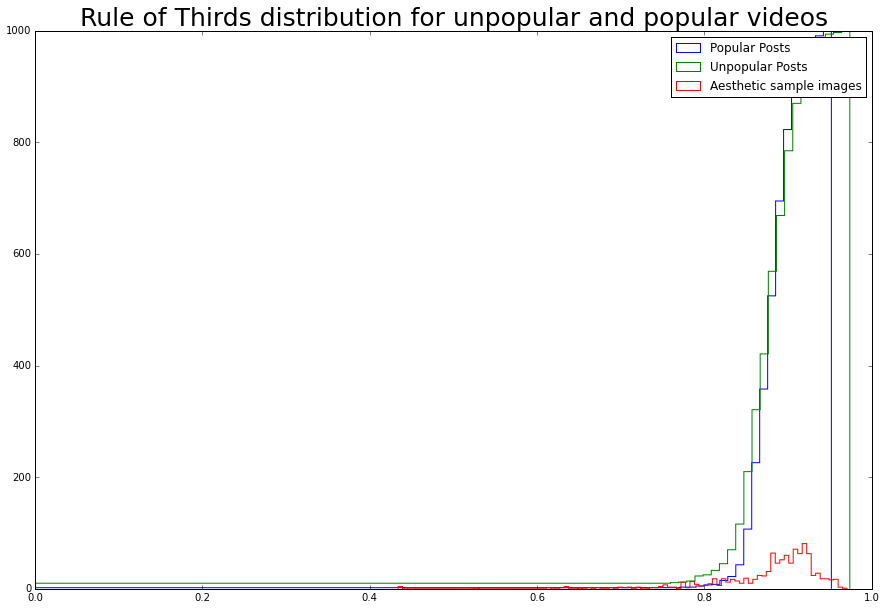

In [37]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.hist(sampledpop_aes_features[:,7], 100, normed=0,histtype='step', cumulative=True, linewidth = 1.0)
plt.hist(sampledunpop_aes_features[:,7], 100, normed=0,histtype='step', cumulative=True, linewidth = 1.0)
plt.hist(sampled_aes[:,7], 100, normed=0,histtype='step', cumulative=False, linewidth = 1.0)
plt.legend(['Popular Posts', 'Unpopular Posts' , 'Aesthetic sample images'])
plt.title('Rule of Thirds distribution for unpopular and popular videos', fontsize = 25)
plt.show()

In [13]:
print np.mean(sampledpop_aes_features[:,7]) , np.var(sampledpop_aes_features[:,7])
print np.mean(unpop_aes_features[:,7]) , np.var(unpop_aes_features[:,7])


0.881782680041 0.00132307373455
0.874083208073 0.00779457560564


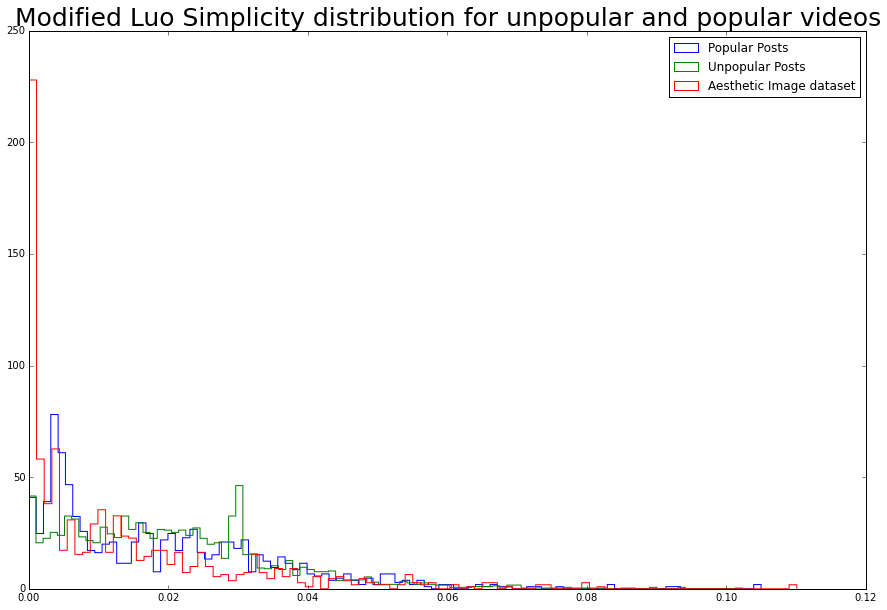

In [26]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.hist(sampledpop_aes_features[:,4], 100, normed=1,histtype='step', cumulative=False, linewidth = 1.0)
plt.hist(unpop_aes_features[:,4], 100, normed=1,histtype='step', cumulative=False, linewidth = 1.0)
plt.hist(sampled_aes[:,4], 100, normed=1,histtype='step', cumulative=False, linewidth = 1.0)
plt.legend(['Popular Posts', 'Unpopular Posts' , 'Aesthetic Image dataset'])
plt.title('Modified Luo Simplicity distribution for unpopular and popular videos', fontsize = 25)
plt.show()

In [55]:
print np.mean(sampledpop_aes_features[:,4]) , np.median(sampledpop_aes_features[:,4])
print np.mean(sampledunpop_aes_features[:,4]) , np.median(unpop_aes_features[:,4])
print np.mean(sampled_aes[:,4]) , np.median(sampled_aes[:,4])
t, p = ttest_ind( sampledpop_aes_features[:,4], sampled_aes[:,4])
print p
t, p = ttest_ind( sampledunpop_aes_features[:,4], sampled_aes[:,4])
print p


0.0189898681641 0.0159301757812
0.0212012939453 0.01904296875
0.0132885742187 0.008056640625
4.67009589285e-15
3.78581034431e-30


In [48]:
print entropy(sampledpop_aes_features, sampled_aes, base=None)
print entropy(sampledunpop_aes_features, sampled_aes, base=None)


[        inf  1.18703631  0.61837575  1.10695919         inf  0.33080034
  1.73838359  0.00560068  0.45441494  0.53175637         inf         inf
         inf         inf         inf         inf  0.03870307         inf
         inf]
[        inf  1.65712829  0.61952795  0.88764102         inf  0.32699705
  1.76465399  0.01378047  0.54601178  0.58289177         inf         inf
         inf         inf         inf         inf  0.08560708         inf
         inf]


/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:4376: RuntimeWarning: divide by zero encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp
/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:4376: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp
/usr/local/lib/python2.7/dist-packages/scipy/stats/_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in greater
  cond1 = (scale > 0) & (x > self.a) & (x < self.b)
/usr/local/lib/python2.7/dist-packages/scipy/stats/_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in less
  cond1 = (scale > 0) & (x > self.a) & (x < self.b)
/usr/local/lib/python2.7/dist-packages/scipy/stats/_distn_infrastructure.py:1749: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


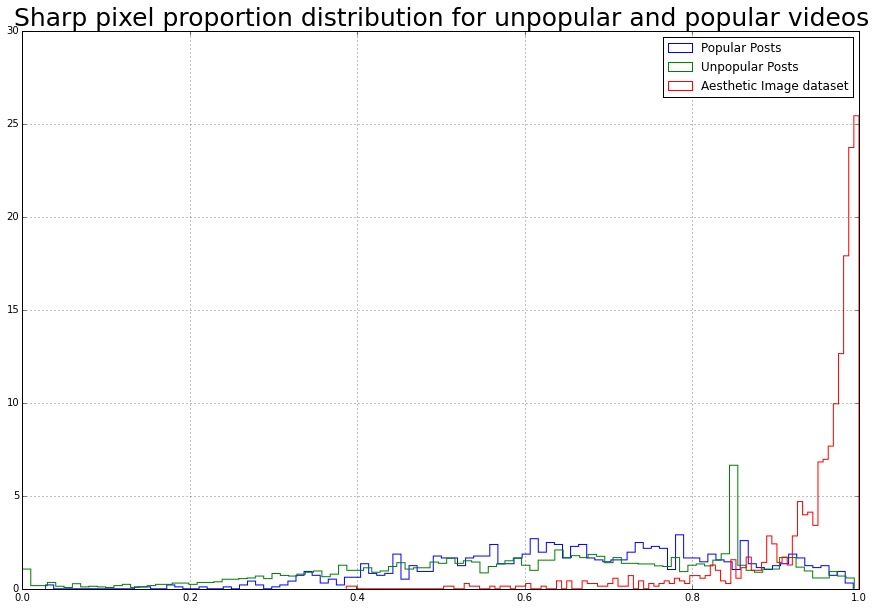

In [16]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.hist(sampledpop_aes_features[:,16], 100, normed=1,histtype='step', cumulative=False, linewidth = 1.0 )
plt.hist(unpop_aes_features[:,16], 100, normed=1,histtype='step', cumulative=False, linewidth = 1.0)
plt.hist(aes_feats[:,16], 100, normed=1,histtype='step', cumulative=False, linewidth = 1.0)
plt.legend(['Popular Posts', 'Unpopular Posts' ,'Aesthetic Image dataset'])
plt.title('Sharp pixel proportion distribution for unpopular and popular videos', fontsize = 25)
plt.grid()
plt.show()

In [17]:
print np.mean(sampledpop_aes_features[:,16]) , np.median(sampledpop_aes_features[:,16])
print np.mean(unpop_aes_features[:,16]) , np.median(unpop_aes_features[:,16])
print np.mean(aes_feats[:,16]) , np.median(aes_feats[:,16])

0.670138137297 0.672628279321
0.619541751516 0.645785590278
0.943023870488 0.973773333333


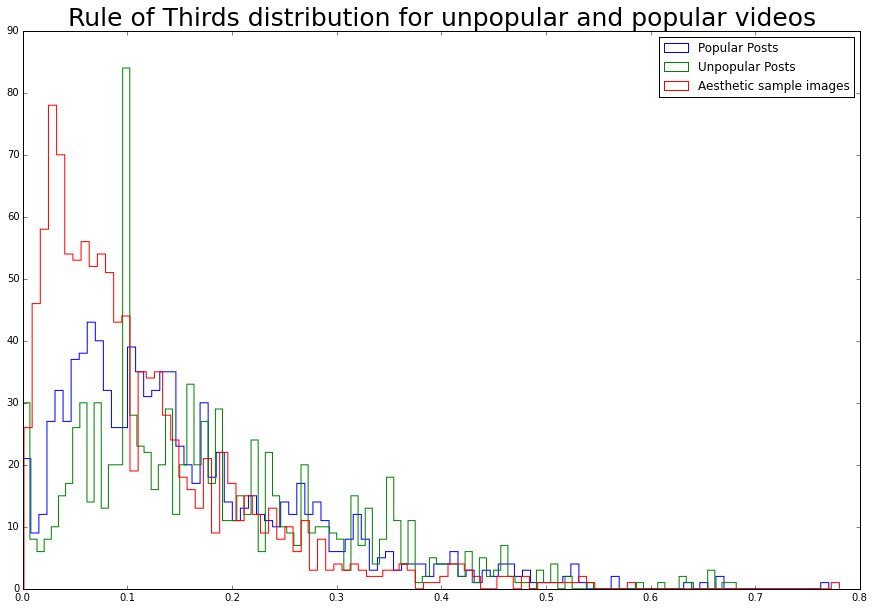

In [18]:
fig, ax = plt.subplots()
num = 2
fig.set_size_inches(15, 10)
plt.hist(sampledpop_aes_features[:,num], 100, normed=0,histtype='step', cumulative=False, linewidth = 1.0)
plt.hist(sampledunpop_aes_features[:,num], 100, normed=0,histtype='step', cumulative=False, linewidth = 1.0)
plt.hist(aes_feats[:,num], 100, normed=0,histtype='step', cumulative=False, linewidth = 1.0)
plt.legend(['Popular Posts', 'Unpopular Posts' , 'Aesthetic sample images'])
plt.title('Rule of Thirds distribution for unpopular and popular videos', fontsize = 25)
plt.show()

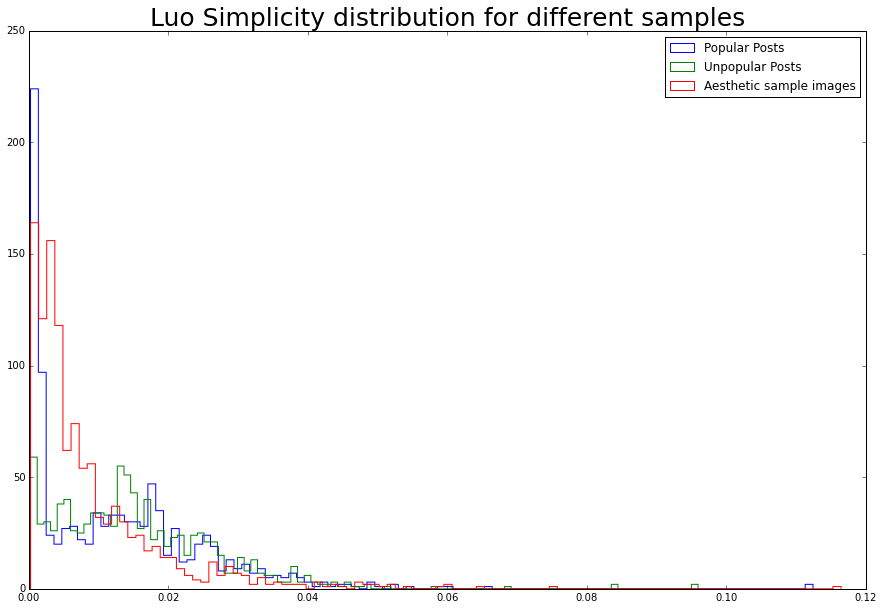

0.0126136474609 0.010498046875
0.0150534002584 0.0135498046875
0.00880691090078 0.005126953125
1.20816990559e-11
5.15148444591e-37


In [56]:
fig, ax = plt.subplots()
num = 3
fig.set_size_inches(15, 10)
plt.hist(sampledpop_aes_features[:,num], 100, normed=0,histtype='step', cumulative=False, linewidth = 1.0)
plt.hist(sampledunpop_aes_features[:,num], 100, normed=0,histtype='step', cumulative=False, linewidth = 1.0)
plt.hist(aes_feats[:,num], 100, normed=0,histtype='step', cumulative=False, linewidth = 1.0)
plt.legend(['Popular Posts', 'Unpopular Posts' , 'Aesthetic sample images'])
plt.title('Luo Simplicity distribution for different samples', fontsize = 25)
plt.show()

print np.mean(sampledpop_aes_features[:,num]) , np.median(sampledpop_aes_features[:,num])
print np.mean(unpop_aes_features[:,num]) , np.median(unpop_aes_features[:,num])
print np.mean(aes_feats[:,num]) , np.median(aes_feats[:,num])
t, p = ttest_ind( sampledpop_aes_features[:,num], sampled_aes[:,num])
print p
t, p = ttest_ind( sampledunpop_aes_features[:,num], sampled_aes[:,num])
print p


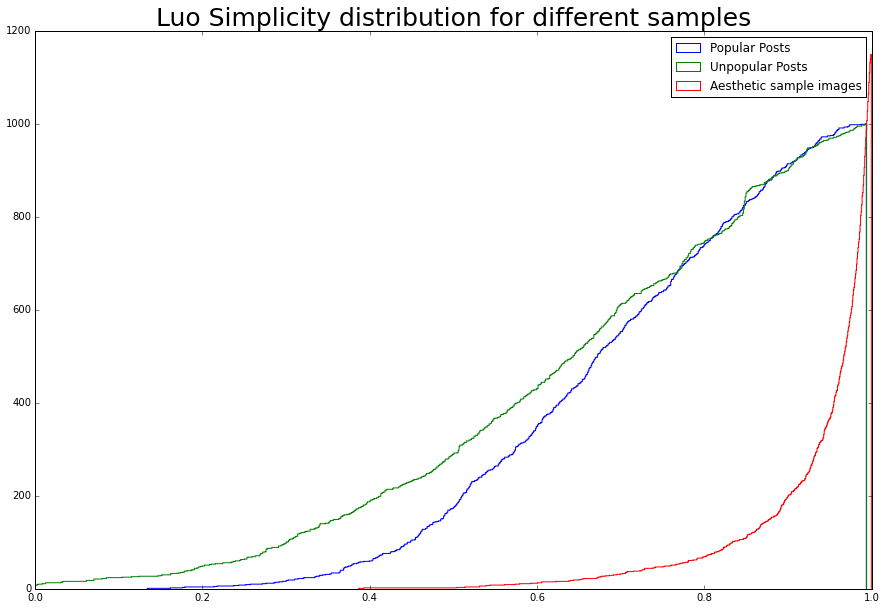

0.669533530093 0.672524112654
0.619541751516 0.645785590278
0.943023870488 0.973773333333


In [42]:
fig, ax = plt.subplots()
num = 16
fig.set_size_inches(15, 10)
plt.hist(sampledpop_aes_features[:,num], 1000, normed=0,histtype='step', cumulative=True, linewidth = 1.0)
plt.hist(sampledunpop_aes_features[:,num], 1000, normed=0,histtype='step', cumulative=True, linewidth = 1.0)
plt.hist(aes_feats[:,num], 1000, normed=0,histtype='step', cumulative=True, linewidth = 1.0)
plt.legend(['Popular Posts', 'Unpopular Posts' , 'Aesthetic sample images'])
plt.title('Luo Simplicity distribution for different samples', fontsize = 25)
plt.show()

print np.mean(sampledpop_aes_features[:,num]) , np.median(sampledpop_aes_features[:,num])
print np.mean(unpop_aes_features[:,num]) , np.median(unpop_aes_features[:,num])
print np.mean(aes_feats[:,num]) , np.median(aes_feats[:,num])